In [2]:
import warnings 
import numpy as np 
import pandas as pd
import scipy.stats
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore') 

In [2]:
from google.colab import drive
drive.mount("/content/drive")
path = '/content/drive/My Drive/Colab Notebooks/'

ModuleNotFoundError: No module named 'google.colab'

In [3]:
path = ''

### Загрузка данных

In [5]:
train = pd.read_csv(path+'kkbox/train.csv')
test = pd.read_csv(path+'kkbox/test.csv')

In [6]:
train.head(5)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [7]:
members = pd.read_csv(path+'kkbox/members.csv')
songs = pd.read_csv(path+'kkbox/songs.csv')
song_extra_info = pd.read_csv(path+'kkbox/song_extra_info.csv')

In [8]:
members.head(1)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920


In [9]:
songs.head(1)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0


In [10]:
song_extra_info.head(1)

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043


Найдем NaNы

In [11]:
def search_nan(df):
    for col in df.columns:
        print(f"numbers of nans = {100*df[col].isna().sum()/len(df)}%, Nan of {col}")

In [12]:
search_nan(members)

numbers of nans = 0.0%, Nan of msno
numbers of nans = 0.0%, Nan of city
numbers of nans = 0.0%, Nan of bd
numbers of nans = 57.849606138999505%, Nan of gender
numbers of nans = 0.0%, Nan of registered_via
numbers of nans = 0.0%, Nan of registration_init_time
numbers of nans = 0.0%, Nan of expiration_date


In [13]:
search_nan(songs)

numbers of nans = 0.0%, Nan of song_id
numbers of nans = 0.0%, Nan of song_length
numbers of nans = 4.0985576923076925%, Nan of genre_ids
numbers of nans = 0.0%, Nan of artist_name
numbers of nans = 46.65525710702341%, Nan of composer
numbers of nans = 84.71240942028986%, Nan of lyricist
numbers of nans = 4.35479375696767e-05%, Nan of language


Примерно в 85% строк датасета songs не известны поэты и в 47% строк не известен композитор у песен. Так что эти данные можно убрать.

In [14]:
songs.drop(['lyricist', 'composer'], axis = 1, inplace = True)

In [15]:
search_nan(song_extra_info)

numbers of nans = 0.0%, Nan of song_id
numbers of nans = 8.710911418306241e-05%, Nan of name
numbers of nans = 5.9472876617344035%, Nan of isrc


Удалим имя песни.

In [16]:
song_extra_info.drop(['name'], axis = 1, inplace = True)

In [17]:
search_nan(test)

numbers of nans = 0.0%, Nan of id
numbers of nans = 0.0%, Nan of msno
numbers of nans = 0.0%, Nan of song_id
numbers of nans = 0.33017963931335775%, Nan of source_system_tab
numbers of nans = 6.3706053293387415%, Nan of source_screen_name
numbers of nans = 0.28539692348608997%, Nan of source_type


In [18]:
search_nan(train)

numbers of nans = 0.0%, Nan of msno
numbers of nans = 0.0%, Nan of song_id
numbers of nans = 0.3368251602389888%, Nan of source_system_tab
numbers of nans = 5.622617560778039%, Nan of source_screen_name
numbers of nans = 0.2919585144829804%, Nan of source_type
numbers of nans = 0.0%, Nan of target


В датафрейме members из registration_init_time и expiration_date достанем год.

In [19]:
for column in ['registration_init_time', 'expiration_date']:
    members[column + '_year'] = members[column].apply(lambda x: int(str(x)[0:4]))      
    members.drop(column, axis=1, inplace=True)

В столбце bd, которая отвечает за возраст есть выбросы (есть слишком большие значения и есть нули). Давайте будем считать, что нет людей, которым больше 100 лет или 0 лет и они слушают музыку. Заменим эи значения на медиану.

In [20]:
idx = np.array(np.where(np.logical_or(members['bd']>100, members['bd'] == 0)))[0]

In [21]:
not_idx = set(range(len(members)))-set(idx)

In [22]:
members['bd'][idx] = np.median(members['bd'][list(not_idx)])

Добавим год песни вместо isrc. Там где isrc неизвестен поставим 2000 год. Таких значений не много, всего 6%. Так что будем считать, что эти песни были написаны где-то между 20 и 21 веком.

In [23]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        val = int(isrc[5:7])
        if val > 17:
            return 1900 + val
        else:
            return 2000 + val
    else:
        return 2000
    
song_extra_info['song_year'] = song_extra_info['isrc'].apply(isrc_to_year)
song_extra_info.drop(['isrc'], axis = 1, inplace = True)

In [24]:
song_extra_info.head(1)

,song_id,song_year
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,2012


Составим train и test датасеты.

In [25]:
train = train.merge(members, on="msno", how='left')
test = test.merge(members, on="msno", how='left')
train = train.merge(songs, on="song_id", how='left')
test = test.merge(songs, on="song_id", how='left')
train = train.merge(song_extra_info, on="song_id", how='left')
test = test.merge(song_extra_info, on="song_id", how='left')

In [26]:
len(train)

7377418

Заменим NaN в жанре на моду, а если несколько жанров, то оставим только один

In [27]:
def genre(df, mode):
    df['genre_ids'] = df['genre_ids'].astype('str').replace('nan', f'{mode}')
    df['genre_ids'] = df['genre_ids'].apply(lambda x: x.split('|')[0])  
    return df

In [28]:
genre_mode = scipy.stats.mode(songs['genre_ids'])
train = genre(train, genre_mode.mode[0])
test = genre(test, genre_mode.mode[0])

Заменим все оставшиеся (например в гендоре) ```Nan``` на ```<UNKNOWN>```

In [208]:
def Nan_unknown(df):
    for i in df.select_dtypes(include=['object']).columns:
        df[i][df[i].isnull()] = '<UNKNOWN>'
    df = df.fillna(value=0)
    return df

In [30]:
train = Nan_unknown(train)
test = Nan_unknown(test)

In [31]:
def other_type(df):
    df.language = df.language.astype(int).astype('category')
    df.city = df.city.astype('category')
    df.song_id = df.song_id.astype('category')
    df.genre_ids = df.genre_ids.astype('category')
    df['song_year'] = df['song_year'].astype('int')
    return df

In [32]:
cat_train = other_type(train)
cat_test = other_type(test)

In [33]:
cat_train.head(5)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time_year,expiration_date_year,song_length,genre_ids,artist_name,language,song_year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,27.0,<UNKNOWN>,7,2012,2017,206471.0,359,Bastille,52,2016
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24.0,female,9,2011,2017,284584.0,1259,Various Artists,52,1999
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24.0,female,9,2011,2017,225396.0,1259,Nas,52,2006
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24.0,female,9,2011,2017,255512.0,1019,Soundway,-1,2010
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,27.0,<UNKNOWN>,7,2012,2017,187802.0,1011,Brett Young,52,2016


In [32]:
#del songs, members, song_extra_info

## Задание №1: GBDT

In [21]:
!pip install catboost

     |████████████████████████████████| 66.2MB 42kB/s 


In [34]:
from catboost import CatBoostClassifier, CatBoostRegressor
from catboost import Pool
from catboost import cv

In [35]:
cat_target = cat_train['target']
cat_train.drop(['target'], axis = 1, inplace = True)

In [36]:
cat_features = [0,1,2,3,4,5,7,8,9,10,12,13,14,15]

In [36]:
train_pool = Pool(data=cat_train, label=cat_target, cat_features=cat_features, has_header=True)

In [26]:
params = {
    'task_type' : 'GPU',
    'loss_function': 'RMSE',
    'iterations': 100
}

Сделаем grid search по парметрам.

In [38]:
model = CatBoostRegressor(**params)

In [ ]:
param_grid = {
    'learning_rate': [0.2, 0.1],
    'depth':[10, 15],
    'l2_leaf_reg': [2, 4, 6]
}

In [40]:
grid_search_results = model.grid_search(param_grid,
            train_pool,
            y=None,
            cv=5,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=None,
            train_size=0.8,
            verbose=True,
            plot=True
            )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.4859149825
bestIteration = 65
0:	loss: 0.4859150	best: 0.4859150 (0)	total: 1m 3s	remaining: 11m 36s
bestTest = 0.4807083189
bestIteration = 98
1:	loss: 0.4807083	best: 0.4807083 (1)	total: 2m	remaining: 10m 1s
bestTest = 0.4614227591
bestIteration = 99
2:	loss: 0.4614228	best: 0.4614228 (2)	total: 2m 58s	remaining: 8m 56s
bestTest = 0.4733013219
bestIteration = 85
3:	loss: 0.4733013	best: 0.4614228 (2)	total: 3m 56s	remaining: 7m 52s
bestTest = 0.4633253557
bestIteration = 75
4:	loss: 0.4633254	best: 0.4614228 (2)	total: 4m 53s	remaining: 6m 51s
bestTest = 0.4754591394
bestIteration = 98
5:	loss: 0.4754591	best: 0.4614228 (2)	total: 5m 51s	remaining: 5m 51s
bestTest = 0.4635782336
bestIteration = 94
6:	loss: 0.4635782	best: 0.4614228 (2)	total: 7m 12s	remaining: 5m 8s
bestTest = 0.4710851583
bestIteration = 95
7:	loss: 0.4710852	best: 0.4614228 (2)	total: 8m 40s	remaining: 4m 20s
bestTest = 0.461869819
bestIteration = 98
8:	loss: 0.4618698	best: 0.4614228 (2)	total: 9m 59

Лучшие параметры

In [42]:
grid_search_results['params']


{'depth': 10, 'l2_leaf_reg': 4, 'learning_rate': 0.2}

In [ ]:
Посмотрим на график обучения и AUC график с этими параметрами

In [25]:
params = {
    'loss_function': 'RMSE',
    'iterations': 100,
    'custom_loss': 'AUC',
    'depth': 10,
    'l2_leaf_reg': 4,
    'learning_rate': 0.2
}

In [26]:
cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [259]:
from PIL import Image

График обучения

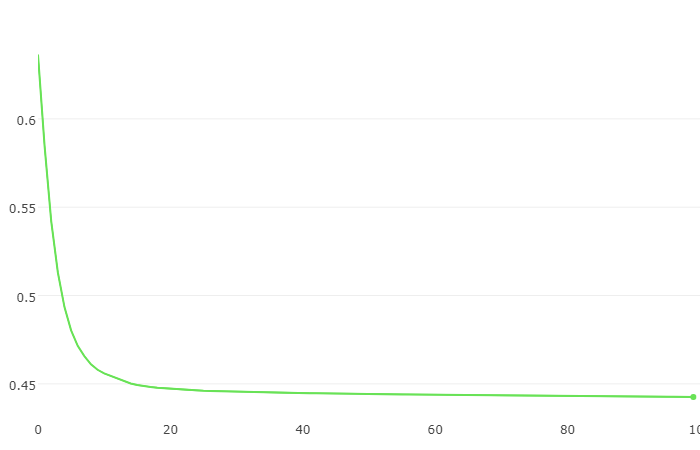

In [129]:
train_plot = Image.open('train.png')
train_plot

AUC

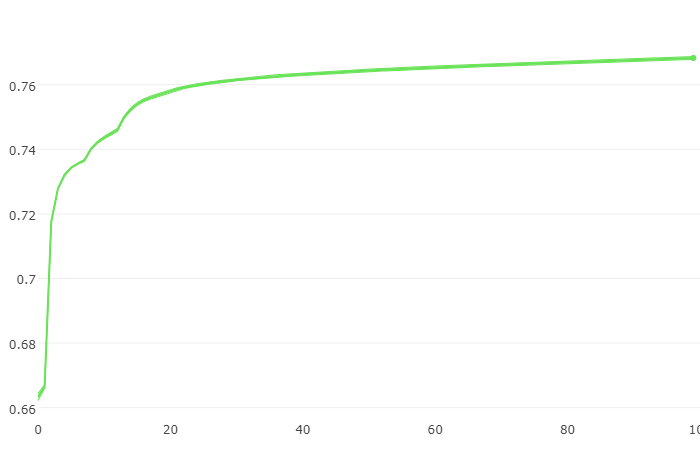

In [130]:
aucplot = Image.open('auc.png')
aucplot

In [27]:
print(f"ROC AUC={cv_data.iloc[-1]['test-AUC-mean']:.4f}±{cv_data.iloc[-1]['test-AUC-std']:.4f}")

ROC AUC=0.7683±0.0004


## Shap value

In [1]:
!pip install shap

In [220]:
import shap

In [8]:
shap_params = {
    'loss_function': 'RMSE',
    'iterations': 100,
    'depth': 10,
    'l2_leaf_reg': 4,
    'learning_rate': 0.2
}

In [37]:
model = CatBoostRegressor(**shap_params)

In [38]:
model.fit(train_pool)

0:	learn: 0.4856398	total: 10.8s	remaining: 17m 48s
1:	learn: 0.4760135	total: 16.9s	remaining: 13m 46s
2:	learn: 0.4695920	total: 22.2s	remaining: 11m 58s
3:	learn: 0.4643785	total: 27.1s	remaining: 10m 49s
4:	learn: 0.4609015	total: 31.9s	remaining: 10m 6s
5:	learn: 0.4585968	total: 36.8s	remaining: 9m 36s
6:	learn: 0.4567899	total: 42s	remaining: 9m 17s
7:	learn: 0.4547566	total: 47.1s	remaining: 9m 2s
8:	learn: 0.4533214	total: 52s	remaining: 8m 45s
9:	learn: 0.4523369	total: 56.4s	remaining: 8m 27s
10:	learn: 0.4515994	total: 1m 1s	remaining: 8m 13s
11:	learn: 0.4506687	total: 1m 5s	remaining: 8m 1s
12:	learn: 0.4500223	total: 1m 10s	remaining: 7m 52s
13:	learn: 0.4494860	total: 1m 15s	remaining: 7m 41s
14:	learn: 0.4491493	total: 1m 19s	remaining: 7m 31s
15:	learn: 0.4488069	total: 1m 24s	remaining: 7m 23s
16:	learn: 0.4485568	total: 1m 28s	remaining: 7m 14s
17:	learn: 0.4483272	total: 1m 33s	remaining: 7m 6s
18:	learn: 0.4481529	total: 1m 38s	remaining: 6m 58s
19:	learn: 0.44790

In [39]:
shap.initjs()

In [40]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(cat_train)

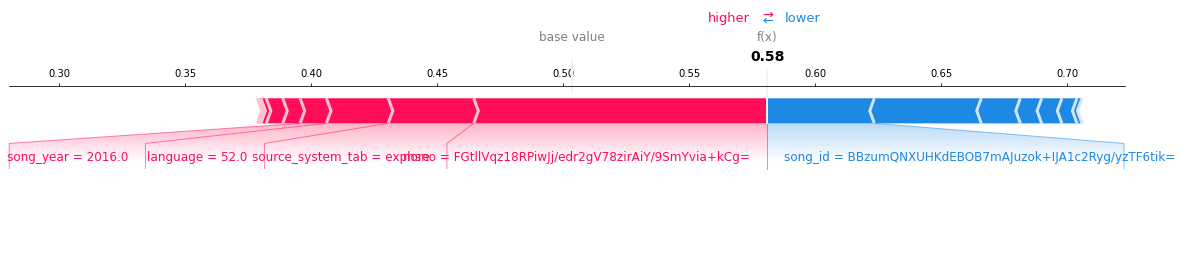

In [42]:
shap.force_plot(explainer.expected_value, shap_values[0,:], cat_train.iloc[0,:], matplotlib=True)

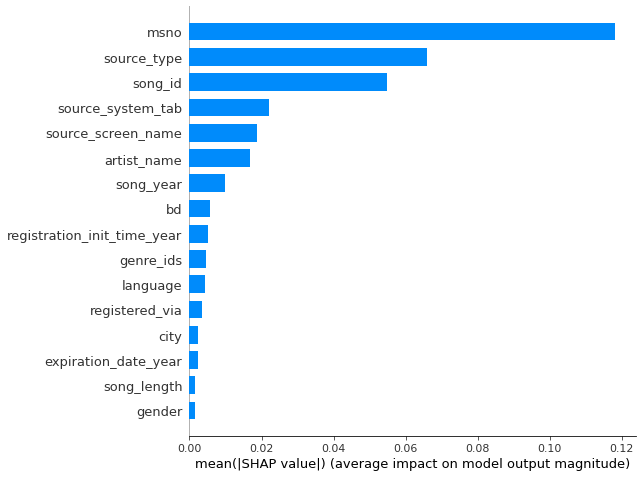

In [43]:
shap.summary_plot(shap_values, cat_train, plot_type="bar")

Видно, что модель считает важными фичи msmo, source_type, song_id. Видимо она запоминает, кто из пользователь какую песню прослушал

## Задание №2: Embeddings

In [38]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [167]:
train = pd.read_csv(path + 'kkbox/train.csv')
test = pd.read_csv(path + 'kkbox/test.csv')

train состоит из более чем 7 миллионов строк. Это обучается все очень долго. Давайте возьмем 1 миллион строк

In [169]:
train= train[:1000000]

Будем обучать эмбеддинги айтомов, а для юзеров возьмем как взвещенное среднее тех айтомов, которые он прослушал.

In [171]:
EMBEDDING_SIZE = 100

In [172]:
train1, test1 = train_test_split(train, test_size = 0.2)

In [173]:
train_w2v = train1[train1['target'] == 1]

In [237]:
target_w2v = train1['target']

Сделаем словарь песен

In [174]:
users = np.unique(train_w2v['msno'].values)
user_history = [train_w2v[train_w2v['msno'] == user]['song_id'].astype(str).tolist() for user in users]

In [357]:
from gensim.models import Word2Vec
model = Word2Vec(window=10, sg=1, hs=0, size=EMBEDDING_SIZE, negative=15, alpha=0.03, min_alpha=0.0007)
model.build_vocab(user_history, progress_per=100)

In [358]:
print(model[model.wv.vocab].shape)

(13189, 100)


In [359]:
model.train(user_history, total_examples=model.corpus_count, epochs=30, report_delay=1)

(13708411, 16593750)

In [360]:
model.init_sims(replace=True)

In [361]:
def get_similars(category_code, top=10):
    similars = model.similar_by_vector(model[category_code], topn=top + 1)
    df = []
    for song_id, similarity in similars:
        info = songs[songs['song_id'] == song_id].to_dict('records')[0]
        info['similarity'] = similarity
        df.append(info)
        
    return pd.DataFrame(df)


In [362]:
code = list(model.wv.vocab.items())[6][0]
get_similars(code)

,song_id,song_length,genre_ids,artist_name,language,similarity
0,d2k4F/IYpmudgfCxsRAXVHBdYHPfcWmhCYmjdXxigLE=,225567,465|1259,玖壹壹,3.0,1.000000
1,3W6VBSN09a/Vh9w1Fwmdus4H4xxmde/yu0RBgMcTtZM=,221622,465|1259,玖壹壹,3.0,0.735983
2,S5bedgihMEByRI+iYTEX6ERZO7RW9t64K3FTQ0BBL1g=,229440,465,玖壹壹,3.0,0.698052
3,pkKADcjPLFdP9kX40L8dlmbLWkgUTqUB0LhurVLSTME=,229152,465,玖壹壹,3.0,0.680374
4,pCf4HI+z4rQsY9FF79m+Sojnl207qtHqtOWU2VFW1ZE=,222144,465,玖壹壹,3.0,0.674931
5,d5ayexvXscdzmuGxENyY8Uwb4AQaxt0dEcnkAgES7xw=,239808,465,玖壹壹,3.0,0.667164
6,c2gmsQ0uEDZQM3lr54HdW+iPmr+a+JWJQ55YZ9oQP60=,213216,465,玖壹壹,3.0,0.663035
7,9YRkIrpN2f9PtHpeYsE03vYy9X7RpIR9XmGtxuyO5iY=,203808,465,玖壹壹,3.0,0.649781
8,q5/Vwifgv0SGdEIyiMU2F0pIXkeCIW3w2xB8n4iMoS0=,202318,465|1259,玖壹壹,3.0,0.647619
9,aDJxUJkOE4a9Dkzx1o7RAB83Nu1UycuG4gObYO3XLi4=,261485,465|1259,玖壹壹,3.0,0.645324


## User embedding

In [234]:
import collections
import tqdm
import sys

In [385]:
def user_embeddings(wv, X_train, y_train):
    user_embeddings = collections.defaultdict(lambda: np.zeros(EMBEDDING_SIZE))
    user_counts = collections.defaultdict(int)
    for (index, row), target in tqdm.tqdm(zip(X_train.iterrows(), y_train), file=sys.stdout):
        if target != 1.0:
            continue
        user_id = row['msno']
        song_id = row['song_id']
        if song_id in wv:
            user_embeddings[user_id] += wv[song_id]
            user_counts[user_id] += 1
    for user_id in user_embeddings.keys():
        user_embeddings[user_id] /= user_counts[user_id]
    return user_embeddings

In [386]:
u_embed = user_embeddings(model.wv, train_w2v, target_w2v)

553125it [01:44, 5287.41it/s]


In [387]:
import csv

In [388]:
df = pd.DataFrame(u_embed)

In [389]:
df

,4pK8Ase2ZizP+fW6g3X4t4vCnU9Gj9X/4pQRzLsY5DI=,fRZ/VQ6Z5J/BC5cdloUtDGaowrnvZcG8Ai6ot893eh0=,NPVZHWfoXanuyNKWxRk0k6x1yRxzBAIP+oSneSv4puE=,qr0OOeGMpBDaMIhEIKb56TpUy3ca68f/MmgkS62VqbM=,iP3eF1In0rH61CfgVmWVYj4CgFcQQ0iVZG7MBA+Plgo=,lwJ8CFWoVEk0tkG87YiUeabItio6Fi7AKCv994UgSpI=,HdnZZ4P0Vjxo2tgTvO1rsT/H3NkG7jvfrnCuF7TBK0A=,9W8/OEq8SKGB2ddhjV3TP7ScljcfyVQbyaOBOaIR/Z8=,Aj7+0rtRGqakpfrVBN9Ap2mcHIJwl6R4At5vS51Y/Qw=,n+lbmH6aVW8wbBiwZ1M9kyhNsYkyMoqy/SnVS7S5qxM=,...,F5cHTXtSvtawpeSXfa6WFoW4DZ6GbbYxl0vnFvlaMgE=,zxMVg3l0frfflcndzaKZwb9qhEXqzpouqIdwOwiPRuA=,xdofcohUsKLo5NqXJfokQI4rilNIFks8iHdpe63v2po=,YsmRD7IZjSsaqxLpQ5SzkIFZ1eXs0wYHHpb9VAX3wts=,1wbBkYB1AOyJrfitu2KuJC9+klX6PGreWmHgMj7vXbI=,w/d4A7XhtmTdlKfxRd7JHlENpSwyq2WMKYcI4VbDkVU=,RC2LB0vdmOVmcN+CwLfTBmDrIDGYiNV97zIOxL4LYfI=,B6Qv+5/wQDYlyFW60wtufVL+hg8K0EWMkaXwlQ+dbyU=,IaDbY4r7yZPuLrDhY+yHAQ6FzyKQZFo99iE7bB7jqGY=,klZwE6vfu35TvI8HbkezlFA+MFBoTpodEMvRYDi0Hz0=
0,-0.020416,0.021981,-0.055914,0.027028,-0.027681,-0.045638,0.022285,-0.048289,-0.033939,-0.061315,...,-0.082307,0.006414,-0.055584,0.099688,-0.055398,-0.089420,-0.112106,0.012846,-0.107205,0.072385
1,0.097906,0.055289,0.089963,0.065328,0.024885,0.093440,0.054384,0.146231,0.079420,0.123895,...,0.059222,0.139314,0.222060,0.035360,0.147602,0.025655,0.002552,0.031606,0.116665,0.090825
2,0.035919,0.017736,0.038538,0.015454,-0.036134,0.034020,-0.015436,0.052212,0.030419,0.042245,...,-0.029245,-0.087529,0.044152,-0.089086,-0.026791,0.109675,-0.306612,-0.055374,0.055450,0.066557
3,-0.020988,-0.028468,-0.114205,-0.073211,-0.034153,-0.051062,-0.021996,-0.099635,-0.028041,-0.104507,...,-0.116796,-0.085700,-0.051988,-0.115353,-0.116293,0.057745,-0.161386,-0.215515,-0.043051,0.076517
4,-0.020627,0.000922,-0.019092,-0.012154,-0.009299,-0.032767,-0.044821,-0.048618,-0.045170,-0.064901,...,0.108080,0.009456,-0.018945,-0.098768,-0.024146,-0.033093,-0.159008,-0.276511,-0.167240,0.068089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.192529,-0.083390,-0.112622,-0.134189,-0.120051,-0.180405,-0.149969,-0.098989,-0.192782,-0.147964,...,-0.025411,-0.266100,-0.189974,-0.209887,-0.085621,-0.095496,-0.112535,-0.200550,-0.198913,-0.133149
96,-0.081149,-0.061440,-0.065784,-0.072116,-0.029463,-0.051680,-0.088591,-0.032112,-0.107623,-0.067173,...,0.032440,0.076915,-0.123344,-0.022777,-0.068414,0.020036,-0.147059,-0.071315,-0.185923,-0.161337
97,0.041440,0.082113,0.051501,0.038330,0.001490,0.060650,0.020214,-0.007592,0.033780,0.082551,...,0.141894,0.012387,0.107413,-0.051183,0.045024,-0.104210,-0.017503,-0.064825,0.115226,-0.006842
98,0.034807,0.005564,0.036243,0.050649,0.079190,0.040666,0.043877,0.064912,0.037832,-0.014017,...,-0.052959,0.046787,0.008043,0.078205,0.008603,0.079528,-0.018744,0.011782,0.047436,-0.029870


In [390]:
(df.T).to_csv('u_embed.csv')

In [391]:
def get_recommendation(user_id, u_embed, wv, songs):
    u_e = u_embed[user_id]
    u_norm = np.linalg.norm(u_e)
    recommend = []
    dots = []
    for song_id in songs:
        s_e = wv[song_id] if song_id in wv else np.zeros(EMBEDDING_SIZE)        
        s_norm = np.linalg.norm(s_e)
        dot_us = np.dot(u_e, s_e)/(u_norm*s_norm)
        recommend.append((song_id, dot_us))
        dots.append(dot_us)
    ind = np.isnan(dots) 
    recommend = [recommend[i] for i in range(len(ind)) if not ind[i]]
    recommend.sort(key = lambda x: x[1], reverse = True)
    return recommend

In [392]:
test1['msno']

476342    8pT8wcLRHos0ZJ+PnuqDFW1D7QM6b7PVVTSKWp1fKzQ=
874383    0WAzZU1GYCwgFJY+zjGFVauHgt4OlNb/TmuC5y+meWI=
852289    reP6sppCKbYq6UiLI+83VmC/EgDWR8X8//pG/pQe/SY=
845823    nujEMhLIMu/q7HjbuUaWma69M4dkh/nN/KiiCTuxPN0=
784790    mSo8xxVyL19A+KDFKsj81wsk4vtPFfyLS6jMtzCaDjM=
                              ...                     
951892    t9dfgO3MBGnLZN8N4LMExm6uW6TwPn3bH+2Hvv6BFWw=
717887    J6U8R16TeYWhrnl/riJeqc7scOwhoBeYz5+3O7ao1mE=
419591    bGilsttcGEcU2CRHjzgYi4XNCQHhbjqK83GX0ETwSQM=
728588    RR9tMl2Tr2Dj/8G5GsEORGCczkeMV3NU6zzUp1MpYPQ=
837627    OG/9hUIMt0ZfRRhiWVd4PStzogiTdCwczqFEccMbIwM=
Name: msno, Length: 200000, dtype: object

In [393]:
user_id  = test1['msno'][837627]
song_id = test1[test1['msno'] == user_id]['song_id']

In [394]:
rec = get_recommendation(user_id, u_embed, model.wv, song_id) 

In [395]:
rec

[('0ee/D6HjX0jSytUn3v58C0x6zEzN4bcPq3WlqvrG/Xo=', 0.6785000206229053),
 ('KZ5hwP74wRO6kRapVIprwodtNdVD2EVD3hkZmmyXFPk=', 0.6722175278991719),
 ('M9rAajz4dYuRhZ7jLvf9RRayVA3os61X/XXHEuW4giA=', 0.6599660843756253),
 ('6HofPS0v2MVFsL10yCN7dXUL+gUOnvsD35vx3HmRbdE=', 0.5597212180136047),
 ('HsgJXv1C7iVZiP7CWwWTfsmMhia6Huc0MUccfj+D02o=', 0.518084987515576),
 ('gmIiPq9H9VBCvBvQwWniWdsHRTx9jhBFod6RqyqYcFQ=', 0.4744681513200042),
 ('rA+H/y66yC2qK0v926aWRFWngwJmL+IhGhJN4fBS0XM=', 0.40948307246084054),
 ('L7Mcxo9zO+J4jzr3LIbp26Qdv0WQIIGct4g/3TRhJmk=', 0.30410321276084673)]

## AUC для Embeddings

In [396]:
from sklearn.metrics import roc_auc_score

In [412]:
def get_dots(wv, user_embed, row):
    user_id = row['msno']
    song_id = row['song_id']
    user_embedding = user_embed[user_id]
    song_embedding = wv[song_id] if song_id in wv else np.zeros(EMBEDDING_SIZE)
    u_norm = np.linalg.norm(user_embedding)
    s_norm = np.linalg.norm(song_embedding)
    dot_us = np.dot(user_embedding, song_embedding)/(u_norm*s_norm)
    if np.isnan(dot_us):
            dot_us = 0
    return dot_us

def data_with_embed(wv, user_embed, data):
    data = data.copy()
    data['dot_us'] = data.apply(lambda row: get_dots(wv, user_embed, row), axis=1)
    return data

In [405]:
target_test1 = test1['target']
score_test1 = get_score(u_embed, model.wv, test)

In [413]:
score_test1 = data_with_embed(model.wv, u_embed, test1)

In [415]:
roc_auc_score(target_test1, score_test1['dot_us'])

0.655052877128705

## Embeddings + GBDT

добавим в каждую строку датасета скалярное произведение эмбеддингов юзера и песни

In [245]:
train1 = train1.merge(members, on="msno", how='left')
train1 = train1.merge(songs, on="song_id", how='left')
train1 = train1.merge(song_extra_info, on="song_id", how='left')
train1 = genre(train1, genre_mode.mode[0])
embed_train = data_with_embed(model.wv, u_embed, train1)
embed_train  = Nan_unknown(embed_train)
embed_train = other_type(embed_train)

In [246]:
embed_train 

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time_year,expiration_date_year,song_length,genre_ids,artist_name,language,song_year,dot_us
0,0WJR7ANEgnbcVQyExFiAX5S/njslsCXyljVxNkfkdec=,PQ60bLYQn4lnOqNp2pmsUziCKclqLai5pemA9rWWQko=,my library,Local playlist more,local-library,0,1,27.0,<UNKNOWN>,4,2016,2017,272718.0,458,田亞霍 (Elvis),3,2016,0.507119
1,mGNHkfgvH4hzwau9L5cYt6A+6XRfGthfw8jwJMmJaB4=,wp1gSQ4LlMEF6bzvEaJl8VdHlAj/EJMTJ0ASrXeddbo=,discover,Local playlist more,local-library,0,1,27.0,<UNKNOWN>,7,2015,2017,236460.0,465,孫子涵 (Niko Sun),3,2016,0.558269
2,YIXFfS8l6La+3Za9fqlPMtlDn7+Q8QQ7GzkYV9q6Cvk=,J3iRhTSYqG12XgzsbOSJYdIFWZ39JaYoP3XSWM/pcHM=,my library,Local playlist more,local-playlist,1,5,25.0,male,3,2015,2017,282017.0,465,五月天 (Mayday),3,2011,0.492416
3,DS8p/aaDqm5Rs4Rg3tx2fnqdFmHiddaaQw2XccMyr+o=,IkWmgUFkyB9TL2dZPuhTkw6tdRszktHg+0u2kiiqdTw=,my library,Local playlist more,local-library,1,15,27.0,<UNKNOWN>,9,2015,2017,249521.0,465,BY2,3,2013,0.473943
4,2HL0NPua3Awucw8aVt4edLUUGtR9R7WyPlbRxZPeP9s=,VlI3/h/GVDnProh6fP0FVySDZEIQfmhLEQTwOfW+SwA=,my library,Local playlist more,local-library,1,1,27.0,<UNKNOWN>,7,2015,2017,208213.0,2022,ONE OK ROCK,17,2008,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,baemFqI4x+fpHweCJQeb64jdSmOWUKkJuwK5BrgcsX0=,9lahsRb7Q1Rku/GnVBExdUMVUZBbEkw9F4NbJZThUO0=,discover,Discover Chart,online-playlist,0,1,27.0,<UNKNOWN>,3,2013,2017,210285.0,465,謝和弦 (R-chord),3,2015,0.472105
799996,qhIZ0wCUhz2GjDedqsSQule+7v5g9tOS1xbxTtNC6fY=,zHFesM1+lJQ2XFyarOt5Oz4rDmcO2QTaPNiSqhi2j20=,my library,Album more,album,1,9,35.0,male,7,2013,2017,183797.0,921,Various Artists,3,2005,0.473910
799997,O/kJJOZmRRUNTy/U5mGPxTi/YSA/2FC3zMSx8woJ+tU=,cQI8Uzy06tt/XJ59vDlifTQTl2qOiTFBkf5yVCUNoyg=,my library,Local playlist more,local-library,1,13,31.0,male,9,2011,2017,245446.0,921,Various Artists,3,2000,0.523335
799998,IO37TczY8BlQ+wt4gd9A6X8VlDComDgjSZEncI6OZek=,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,my library,Local playlist more,local-library,1,1,27.0,<UNKNOWN>,7,2010,2017,205914.0,1609,DJ Snake,52,2016,0.718665


In [247]:
embed_target = embed_train['target']
embed_train.drop(['target'], axis = 1, inplace = True)

In [248]:
train_pool = Pool(data=embed_train, label=embed_target, cat_features=cat_features, has_header=True)

In [249]:
params = {
    'loss_function': 'RMSE',
    'iterations': 100,
    'custom_loss': 'AUC',
    'depth': 10,
    'l2_leaf_reg': 4,
    'learning_rate': 0.2
}

In [250]:
cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

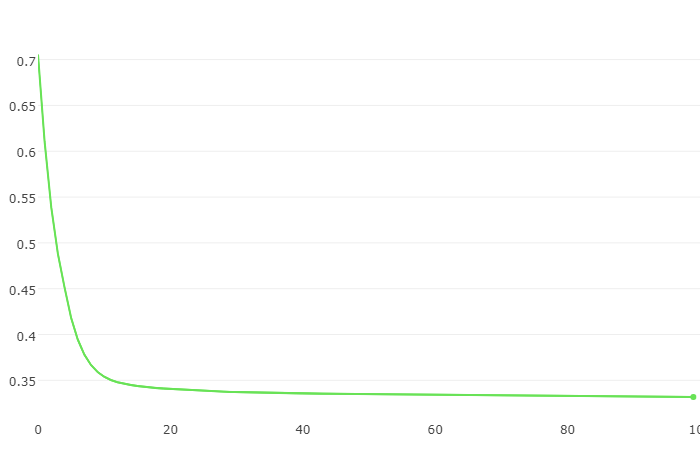

In [260]:
train_plot1 = Image.open('train1.png')
train_plot1

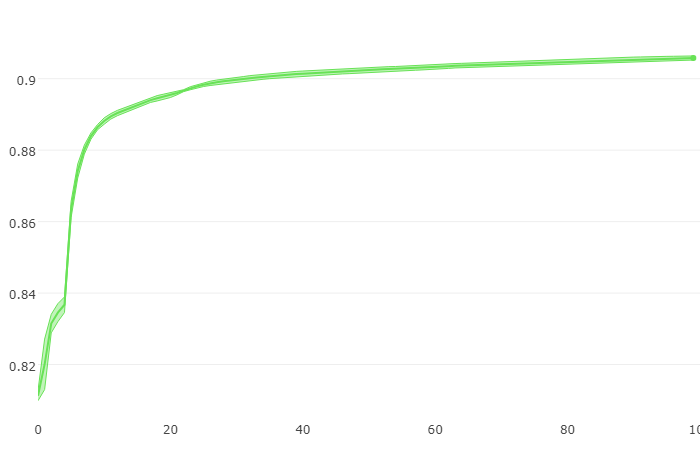

In [261]:
auc_plot1 = Image.open('auc1.png')
auc_plot1

In [262]:
print(f"ROC AUC={cv_data.iloc[-1]['test-AUC-mean']:.4f}±{cv_data.iloc[-1]['test-AUC-std']:.4f}")

ROC AUC=0.9058±0.0006


In [252]:
shap_params = {
    'loss_function': 'RMSE',
    'iterations': 100,
    'depth': 10,
    'l2_leaf_reg': 4,
    'learning_rate': 0.2
}
model_embed = CatBoostRegressor(**shap_params)
model_embed.fit(train_pool)

0:	learn: 0.4267848	total: 695ms	remaining: 1m 8s
1:	learn: 0.4016028	total: 1.32s	remaining: 1m 4s
2:	learn: 0.3849144	total: 1.81s	remaining: 58.4s
3:	learn: 0.3729094	total: 2.4s	remaining: 57.5s
4:	learn: 0.3645851	total: 2.91s	remaining: 55.3s
5:	learn: 0.3587749	total: 3.42s	remaining: 53.6s
6:	learn: 0.3549906	total: 3.96s	remaining: 52.6s
7:	learn: 0.3520003	total: 4.46s	remaining: 51.2s
8:	learn: 0.3499976	total: 4.95s	remaining: 50.1s
9:	learn: 0.3483293	total: 5.45s	remaining: 49s
10:	learn: 0.3471463	total: 5.95s	remaining: 48.1s
11:	learn: 0.3460717	total: 6.46s	remaining: 47.4s
12:	learn: 0.3452955	total: 6.97s	remaining: 46.7s
13:	learn: 0.3446478	total: 7.49s	remaining: 46s
14:	learn: 0.3440899	total: 7.99s	remaining: 45.3s
15:	learn: 0.3436405	total: 8.52s	remaining: 44.7s
16:	learn: 0.3432756	total: 9.01s	remaining: 44s
17:	learn: 0.3426034	total: 9.55s	remaining: 43.5s
18:	learn: 0.3420655	total: 10.1s	remaining: 43s
19:	learn: 0.3416381	total: 10.6s	remaining: 42.5s

In [253]:
shap.initjs()

In [254]:
explainer = shap.TreeExplainer(model_embed)
shap_values = explainer.shap_values(embed_train)

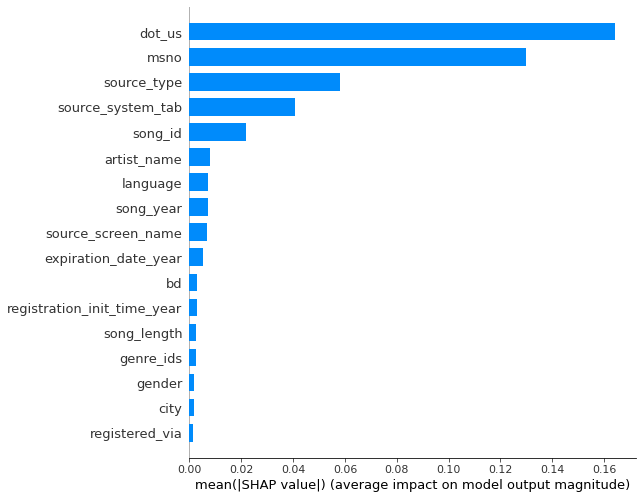

In [256]:
shap.summary_plot(shap_values, embed_train, plot_type="bar")